### Continuous Bag of Words (CBOW) Model

The CBOW model architecture tries to predict the current target word (the center word) based on the source context words (surrounding words). Considering a simple sentence, __"the quick brown fox jumps over the lazy dog"__, this can be pairs of __(context_window, target_word)__ where if we consider a context window of size 2, we have examples like __([quick, fox], brown), ([the, brown], quick), ([the, dog], lazy)__ and so on. Thus the model tries to predict the __target_word__ based on the __context_window_words__.

In [9]:
import spacy
import numpy as np
import re
import matplotlib.pyplot as plt
from helpers import vocab_utils
from tqdm import tqdm

# Pytorch
import torch
import torch.nn as nn

In [10]:
# Make sure that the spacy english model is installed
if not spacy.util.is_package("en_core_web_sm"):
    spacy.cli.download("en_core_web_sm")
    
# Load the english model
nlp = spacy.load("en_core_web_sm", disable=["ner"])

In [11]:
# The shakespeare.txt contains multiple lines of text, quoted with double quotes.
# Let's read each line and remove the double quotes, then append the line to a list.
read_lines = []
with open('Data/shakespeare.txt') as f:
    for line in f:
        # Regular expression to remove double quotes at beginning and end of line
        line = re.sub(r'^"|"\n$', '', line)
        read_lines.append(line)
        
# We will combine lines that end with a dot as a single sentence.
sentences = []
current_sentence = ''
for i in range(len(read_lines)):
    # Find the first index of a dot in the line. If it exists, append the line to the current sentence containing the dot, cut off the rest of the line, decrease the i counter by 1 and continue.
    # If it doesn't exist, append the line to the current sentence and continue.
    dot_index = read_lines[i].find('.')
    
    if dot_index != -1:
        # Append the line to the current sentence
        current_sentence +=  ' ' + read_lines[i][:dot_index+1]
        # Cut off the rest of the line
        read_lines[i] = read_lines[i][dot_index+1:]
        # Append the current sentence to the list of sentences
        sentences.append(current_sentence.strip())
        # Reset the current sentence
        current_sentence = ''
        # Decrease the i counter by 1 so that the current line is processed again
        i -= 1
    else:
        # Append the line to the current sentence
        current_sentence += ' ' + read_lines[i]
        
# If the current sentence is not empty, append it to the list of sentences as well
if current_sentence != '':
    sentences.append(current_sentence.strip())
    
# Let's print the first 10 sentences
for i in range(10):
    print(sentences[i])

ACT I SCENE I.
Enter KING HENRY, LORD JOHN OF LANCASTER, the EARL of WESTMORELAND, SIR WALTER BLUNT, and others So shaken as we are, so wan with care, Find we a time for frighted peace to pant, And breathe short-winded accents of new broils To be commenced in strands afar remote.
No more the thirsty entrance of this soil Shall daub her lips with her own children's blood, Nor more shall trenching war channel her fields, Nor bruise her flowerets with the armed hoofs Of hostile paces: those opposed eyes, Which, like the meteors of a troubled heaven, All of one nature, of one substance bred, Did lately meet in the intestine shock And furious close of civil butchery Shall now, in mutual well-beseeming ranks, March all one way and be no more opposed Against acquaintance, kindred and allies: The edge of war, like an ill-sheathed knife, No more shall cut his master.
As far as to the sepulchre of Christ, Whose soldier now, under whose blessed cross We are impressed and engaged to fight, Forthwi

In [12]:
# Use spacy tokenizer to clean the text
def spacy_text_clean(text):
    """
    This function uses the spacy tokenizer to clean the text
    
    Args:
        text (str): The text to be cleaned
        
    Returns:
        tokens: A list of tokens that have been cleaned
    """
    
    # Create a spacy object
    doc = nlp(text)
    
    # Tokenize the text
    tokens = []
    for token in doc:
        if token.is_alpha:
            tokens.append(token.lower_)
        elif token.is_punct:
            tokens.append(token.text)
    
    return tokens

In [13]:
# Test the function
text = "Hello, world! This is a test."
print(spacy_text_clean(text))

['hello', ',', 'world', '!', 'this', 'is', 'a', 'test', '.']


In [14]:
# Initialize the token list
cleaned_tokens = []

# For each batch of sentences, append them then clean them
batch = 100
for i in tqdm(range(0, len(sentences), batch)):
    cleaned_tokens.extend(spacy_text_clean(' '.join(sentences[i:i+batch])))

  0%|          | 0/341 [00:00<?, ?it/s]

100%|██████████| 341/341 [00:55<00:00,  6.10it/s]


In [15]:
# Print the size of the cleaned tokens
print(len(cleaned_tokens))

946795


In [16]:
# Print the first 1000 tokens
print(cleaned_tokens[:1000])

['act', 'i', 'scene', 'enter', 'king', 'henry', ',', 'lord', 'john', 'of', 'lancaster', ',', 'the', 'earl', 'of', 'westmoreland', ',', 'sir', 'walter', 'blunt', ',', 'and', 'others', 'so', 'shaken', 'as', 'we', 'are', ',', 'so', 'wan', 'with', 'care', ',', 'find', 'we', 'a', 'time', 'for', 'frighted', 'peace', 'to', 'pant', ',', 'and', 'breathe', 'short', '-', 'winded', 'accents', 'of', 'new', 'broils', 'to', 'be', 'commenced', 'in', 'strands', 'afar', 'remote', '.', 'no', 'more', 'the', 'thirsty', 'entrance', 'of', 'this', 'soil', 'shall', 'daub', 'her', 'lips', 'with', 'her', 'own', 'children', 'blood', ',', 'nor', 'more', 'shall', 'trenching', 'war', 'channel', 'her', 'fields', ',', 'nor', 'bruise', 'her', 'flowerets', 'with', 'the', 'armed', 'hoofs', 'of', 'hostile', 'paces', ':', 'those', 'opposed', 'eyes', ',', 'which', ',', 'like', 'the', 'meteors', 'of', 'a', 'troubled', 'heaven', ',', 'all', 'of', 'one', 'nature', ',', 'of', 'one', 'substance', 'bred', ',', 'did', 'lately', 'm

### Build a vocabulary of words from our dataset

In [17]:
# Build a vocabulary from the tokens, with cutoff of 25
vocab = vocab_utils.vocabulary_from_tokens(cleaned_tokens)

In [18]:
# Print the size of the vocabulary
print("Vocabulary size:", vocab['count'])

Vocabulary size: 2517


In [19]:
# Print the first 100 words in the vocabulary
print("First 100 words in the vocabulary:", list(vocab['word2idx'].keys())[:100])

First 100 words in the vocabulary: ['<UNK>', '<PAD>', '<EOS>', 'act', 'i', 'scene', 'enter', 'king', 'henry', ',', 'lord', 'john', 'of', 'lancaster', 'the', 'earl', 'westmoreland', 'sir', 'blunt', 'and', 'others', 'so', 'as', 'we', 'are', 'with', 'care', 'find', 'a', 'time', 'for', 'peace', 'to', 'breathe', 'short', '-', 'new', 'be', 'in', '.', 'no', 'more', 'this', 'shall', 'her', 'lips', 'own', 'children', 'blood', 'nor', 'war', 'fields', 'armed', ':', 'those', 'opposed', 'eyes', 'which', 'like', 'troubled', 'heaven', 'all', 'one', 'nature', 'substance', 'bred', 'did', 'lately', 'meet', 'close', 'civil', 'now', 'well', 'march', 'way', 'against', 'acquaintance', 'kindred', 'edge', 'an', 'ill', 'knife', 'cut', 'his', 'master', 'far', 'whose', 'soldier', 'under', 'blessed', 'cross', 'fight', 'power', 'english', 'arms', 'were', 'their', "'", 'womb', 'chase']


### Prepare data for CBOW model

In [20]:
def extract_context_target(sentence, window_size=2):
    """
    This function extracts the context and target words from a sentence
    
    Args:
        sentence (list): A list of tokens in the sentence
        window_size (int): The size of the context window
        
    Returns:
        context_target_pairs (list): A list of tuples containing the context and target words
    """
    
    # Initialize the list of context and target pairs
    context_target_pairs = []
    
    # For each word in the sentence
    for i in range(len(sentence)):
        # Extract the context words
        context_words = []
        for j in range(i-window_size, i+window_size+1):
            if j != i and j >= 0 and j < len(sentence):
                context_words.append(sentence[j])
        
        # Extract the target word
        target_word = sentence[i]
        
        # Append the context and target words to the list of pairs only if the context words containing enough words
        if len(context_words) == 2*window_size:
            context_target_pairs.append((context_words, target_word))
        
    return context_target_pairs

In [21]:
## Test the function
sentence = sentences[1]
print(sentence)

# Tokenize the sentence
tokens = spacy_text_clean(sentence)
print(tokens)

# Extract the context and target words
context_target_pairs = extract_context_target(tokens)
print(context_target_pairs)

Enter KING HENRY, LORD JOHN OF LANCASTER, the EARL of WESTMORELAND, SIR WALTER BLUNT, and others So shaken as we are, so wan with care, Find we a time for frighted peace to pant, And breathe short-winded accents of new broils To be commenced in strands afar remote.
['enter', 'king', 'henry', ',', 'lord', 'john', 'of', 'lancaster', ',', 'the', 'earl', 'of', 'westmoreland', ',', 'sir', 'walter', 'blunt', ',', 'and', 'others', 'so', 'shaken', 'as', 'we', 'are', ',', 'so', 'wan', 'with', 'care', ',', 'find', 'we', 'a', 'time', 'for', 'frighted', 'peace', 'to', 'pant', ',', 'and', 'breathe', 'short', '-', 'winded', 'accents', 'of', 'new', 'broils', 'to', 'be', 'commenced', 'in', 'strands', 'afar', 'remote', '.']
[(['enter', 'king', ',', 'lord'], 'henry'), (['king', 'henry', 'lord', 'john'], ','), (['henry', ',', 'john', 'of'], 'lord'), ([',', 'lord', 'of', 'lancaster'], 'john'), (['lord', 'john', 'lancaster', ','], 'of'), (['john', 'of', ',', 'the'], 'lancaster'), (['of', 'lancaster', 'the'

In [22]:
# Define a function create a one-hot vector from a word
def one_hot_vector(vocab, word):
    """
    This function creates a one-hot vector from a word
    
    Args:
        vocab (dict): The vocabulary dictionary
        word (str): The word to be converted to a one-hot vector
        
    Returns:
        one_hot (np.array): A one-hot vector representation of the word
    """
    
    # Initialize the one-hot vector
    one_hot = np.zeros(vocab['count'])
    
    # Set the index of the word to 1
    one_hot[vocab_utils.lookup_token(vocab, word)] = 1
    
    return one_hot

In [23]:
# Test the function
word = 'king'
one_hot = one_hot_vector(vocab, word)
print(one_hot)

[0. 0. 0. ... 0. 0. 0.]


In [24]:
def generate_context_target_pairs(sentences, window_size=2):
    """
    This function generates the context and target pairs from a list of sentences
    
    Args:
        sentences (list): A list of sentences
        window_size (int): The size of the context window
        
    Returns:
        context_target_pairs (list): A list of tuples containing the context and target words
    """
    
    # Initialize the list of context and target pairs
    context_target_pairs = []
    
    # For each sentence
    print(f'Generating context and target pairs from {len(sentences)} sentences')
    for sentence in tqdm(sentences):
        # Tokenize the sentence
        tokens = spacy_text_clean(sentence)
        
        # Extract the context and target words
        pairs = extract_context_target(tokens, window_size)
        
        # Append the pairs to the list of context and target pairs
        context_target_pairs.extend(pairs)
        
    # Shuffle the pairs
    np.random.shuffle(context_target_pairs)
        
    return context_target_pairs

In [25]:
def context_target_to_one_hot(vocab, context_target_pairs, batch_size=128):
    """
    This function yields a batch of context and target one-hot vectors from a list of sentences
    
    Args:
        vocab (dict): The vocabulary dictionary
        context_target_pairs (list): A list of tuples containing the context and target words
        batch_size (int): The batch size
        
    Returns:
        yield (tuple): A tuple containing the context and target one-hot vectors
    """
    
    # For each batch of context and target pairs
    for i in range(0, len(context_target_pairs), batch_size):
        # If i is equal to or greater than the length of the context and target pairs, break
        if i >= len(context_target_pairs):
            break
        
        # Initialize the context and target one-hot vectors
        context_one_hot = np.zeros((batch_size, vocab['count']))
        target_one_hot = np.zeros((batch_size, vocab['count']))
        
        # For each pair in the batch
        for j in range(i, i+batch_size):
            # Avoid index out of bounds
            if j >= len(context_target_pairs):
                # Change j to the last index
                j = len(context_target_pairs)-1
            
            # Extract the context and target words
            context_words, target_word = context_target_pairs[j]
            
            # Create the context one-hot vector
            context_one_hot[j-i] = np.mean([one_hot_vector(vocab, word) for word in context_words], axis=0)
            
            # Create the target one-hot vector
            target_one_hot[j-i] = one_hot_vector(vocab, target_word)
        
        # Preferably, yield the context and target one-hot vectors as torch tensors on the GPU
        # yield (torch.from_numpy(context_one_hot).float(), torch.from_numpy(target_one_hot).float())
        if torch.cuda.is_available():
            yield (torch.from_numpy(context_one_hot).float().cuda(), torch.from_numpy(target_one_hot).float().cuda())
        else:
            yield (torch.from_numpy(context_one_hot).float(), torch.from_numpy(target_one_hot).float())

### Create CBOW model architecture

In [33]:
def initialize_model(vocab_size, embedding_dim):
    """
    This function initializes a continuous bag of words model
    
    Args:
        vocab_size (int): The size of the vocabulary
        embedding_dim (int): The size of the embedding dimension
        
    Returns:
        model: The initialized pytorch model
    """
    
    # Initialize the model
    model = nn.Sequential(
        # First layer has vocab_size inputs and embedding_dim outputs
        nn.Linear(vocab_size, embedding_dim),
        nn.ReLU(),
        # Second layer has embedding_dim inputs and vocab_size outputs
        nn.Linear(embedding_dim, vocab_size)
    )
    
    # Preferably, move the model to the GPU
    if torch.cuda.is_available():
        model.cuda()
        
    return model

In [34]:
# Initialize the model
model = initialize_model(vocab['count'], 100)

In [35]:
# Print the model
print(model)

Sequential(
  (0): Linear(in_features=2517, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=2517, bias=True)
)


In [36]:
def train_model(model, train_context_target_pairs, validate_context_target_pairs, epochs=10, lr=0.001, batch_size=100):
    """
    This function trains a pytorch model on a dataset
    
    Args:
        model: The pytorch model to be trained
        train_context_target_pairs (list): A list of tuples containing the context and target words for training
        validate_context_target_pairs (list): A list of tuples containing the context and target words for validation
        epochs (int): The number of epochs
        lr (float): The learning rate
        batch_size (int): The batch size
        
    Returns:
        model: The trained pytorch model
    """
    
    # Store the training and validation losses
    train_losses = []
    validate_losses = []

    # Define the loss function
    loss_function = nn.BCEWithLogitsLoss()
    
    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # For each epoch
    for epoch in range(epochs):
        # Initialize the training loss
        train_loss = 0
        
        # Set the model to training mode
        model.train()
        
        # For each batch of context and target one-hot vectors
        for context, target in context_target_to_one_hot(vocab, train_context_target_pairs, batch_size=batch_size):
            # Reset the gradients
            optimizer.zero_grad()
            
            # Make predictions
            predictions = model(context)
            
            # Calculate the loss
            loss = loss_function(predictions, target)
            
            # Backpropagate the loss
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Add the loss to the training loss
            train_loss += loss.item()
            
        # Normalize the training loss
        train_loss /= len(train_context_target_pairs)
        
        # Add the training loss to the list of training losses
        train_losses.append(train_loss)
            
        # Print the training loss
        print("Epoch:", epoch+1, "Training loss:", train_loss)
        
        # Initialize the validation loss
        validate_loss = 0
        
        # Set the model to evaluation mode
        model.eval()
        
        # For each batch of context and target one-hot vectors
        for context, target in context_target_to_one_hot(vocab, validate_context_target_pairs, batch_size=batch_size):
            # Make predictions
            predictions = model(context)
            
            # Calculate the loss
            loss = loss_function(predictions, target)
            
            # Add the loss to the validation loss
            validate_loss += loss.item()
            
        # Normalize the validation loss
        validate_loss /= len(validate_context_target_pairs)
        
        # Add the validation loss to the list of validation losses
        validate_losses.append(validate_loss)
            
        # Print the validation loss
        print("Epoch:", epoch+1, "Validation loss:", validate_loss)
        
    return model, train_losses, validate_losses

In [37]:
# Split the sentences into training and validation sets
shuffle_indices = np.random.permutation(len(sentences))
train_sentences = [sentences[i] for i in shuffle_indices[:int(len(sentences)*0.8)]]
validate_sentences = [sentences[i] for i in shuffle_indices[int(len(sentences)*0.8):]]

In [38]:
# Generate the context and target pairs for the training and validation sets
train_context_target_pairs = generate_context_target_pairs(train_sentences)
validate_context_target_pairs = generate_context_target_pairs(validate_sentences)

Generating context and target pairs from 27232 sentences


100%|██████████| 27232/27232 [01:36<00:00, 282.15it/s]


Generating context and target pairs from 6808 sentences


100%|██████████| 6808/6808 [00:25<00:00, 267.09it/s]


In [39]:
# Train the model
model, train_losses, validate_losses = train_model(model, train_context_target_pairs, validate_context_target_pairs, epochs=10, lr=0.001, batch_size=200)

Epoch: 1 Training loss: 8.837177999125867e-05
Epoch: 1 Validation loss: 1.286609402516686e-05
Epoch: 2 Training loss: 1.2809699251197101e-05
Epoch: 2 Validation loss: 1.2712779676341018e-05
Epoch: 3 Training loss: 1.2532187426502766e-05
Epoch: 3 Validation loss: 1.2238829258572894e-05
Epoch: 4 Training loss: 1.1957012434312268e-05
Epoch: 4 Validation loss: 1.1693672537015175e-05
Epoch: 5 Training loss: 1.1503789787238064e-05
Epoch: 5 Validation loss: 1.1378469986710027e-05
Epoch: 6 Training loss: 1.1236062804687195e-05
Epoch: 6 Validation loss: 1.1207570756432245e-05
Epoch: 7 Training loss: 1.1063133389462257e-05
Epoch: 7 Validation loss: 1.1098585523647353e-05
Epoch: 8 Training loss: 1.0933104906055643e-05
Epoch: 8 Validation loss: 1.1019999692733033e-05
Epoch: 9 Training loss: 1.082608949329442e-05
Epoch: 9 Validation loss: 1.0959479388047216e-05
Epoch: 10 Training loss: 1.0734578504406137e-05
Epoch: 10 Validation loss: 1.091228175370547e-05


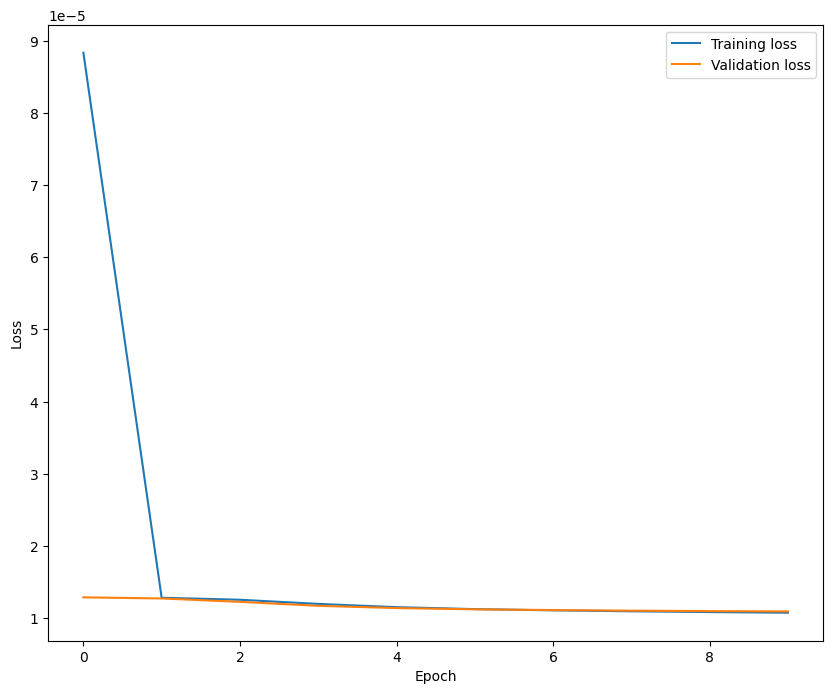

In [40]:
# Draw the training and validation losses
plt.figure(figsize=(10, 8))
plt.plot(train_losses, label='Training loss')
plt.plot(validate_losses, label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Get Word Embeddings by calculating mean of the W1 and W2 weight matrices

In [41]:
def get_embedding(model):
    """
    This function gets the embedding matrix of all words, by calculating the mean of the weight matrix of the first layer of the model and the second layer of the model
    
    Args:
        model: The pytorch model
        
    Returns:
        embedding (np.array): The embedding of the word
    """
    
    # Get the weight matrix of the first layer
    weight1 = model[0].weight.data.cpu().numpy()
    
    # Get the weight matrix of the second layer
    weight2 = model[2].weight.data.cpu().numpy()
    
    # Calculate the mean of the two weight matrices (transpose first layer weight matrix)
    all_embeddings = (weight1.T + weight2) / 2
    
    return all_embeddings

In [42]:
# Calculate the embedding matrix of all words
all_embeddings = get_embedding(model)

In [43]:
# Print the shape of the embedding
print(all_embeddings.shape)

(2517, 100)


In [44]:
# Define a function to get the embedding of a word
def get_word_embedding(word, all_embeddings, vocab):
    """
    This function gets the embedding of a word
    
    Args:
        word (str): The word to be embedded
        all_embeddings (np.array): The embedding matrix
        vocab (dict): The vocabulary dictionary
        
    Returns:
        embedding (np.array): The embedding of the word
    """
    
    # Get the index of the word
    index = vocab_utils.lookup_token(vocab, word)
    
    # Return the embedding
    return all_embeddings[index]

In [45]:
# Test the function
word = 'king'
word_embedding = get_word_embedding(word, all_embeddings, vocab)
print(word_embedding)

[ 4.48076576e-02  1.64634913e-01 -6.74484015e-01  1.80700362e-01
  3.82556021e-01  1.94576442e-01 -8.54499459e-01 -1.92681588e-02
 -1.64464399e-01 -1.99554235e-01 -9.03800488e-01  2.21777335e-01
 -6.02526665e-02  5.71528733e-01 -1.07038945e-01  1.97753385e-02
 -3.15813780e-01 -3.96371603e-01 -2.82632619e-01 -5.75842559e-02
 -7.52269709e-03 -3.42431664e-01  5.19586980e-01  7.50028908e-01
 -1.09954268e-01 -5.30472577e-01 -1.09134391e-01  8.05588905e-04
  3.11922461e-01  5.23508430e-01 -3.77018511e-01 -2.51066595e-01
 -3.50451469e-01  1.51424468e-01  1.40312240e-01  5.22333011e-02
  2.24427551e-01 -1.50186300e-01 -6.31714940e-01 -4.16963637e-01
  7.55169332e-01  2.98405230e-01 -3.85400355e-02  1.47878844e-02
 -6.77050114e-01  5.15243039e-04 -2.90218115e-01 -4.15866464e-01
  2.00566918e-01  3.81082296e-04  1.43253684e-01 -2.24573761e-01
  3.27882975e-01  1.49971470e-01  7.43446872e-05 -3.96475017e-01
  1.73591018e-01 -3.62475097e-01 -5.25295556e-01  3.10391665e-01
 -2.18497198e-02 -7.98330

In [46]:
# Define a function to get the most similar words to a word
def get_most_similar_words(word, all_embeddings, vocab, n=10):
    """
    This function gets the most similar words to a word
    
    Args:
        word (str): The word to be embedded
        all_embeddings (np.array): The embedding matrix
        vocab (dict): The vocabulary dictionary
        n (int): The number of similar words to return
        
    Returns:
        similar_words (list): A list of tuples containing the similar words and their cosine similarity
    """
    
    # Get the embedding of the word
    word_embedding = get_word_embedding(word, all_embeddings, vocab)
    
    # Calculate the cosine similarity between the word and all other words
    cosine_similarity = np.dot(all_embeddings, word_embedding) / (np.linalg.norm(all_embeddings, axis=1) * np.linalg.norm(word_embedding))
    
    # Get the indices of the most similar words
    similar_word_indices = np.argsort(cosine_similarity)[::-1][1:n+1]
    
    # Get the similar words and their cosine similarity
    similar_words = [(vocab['idx2word'][index], cosine_similarity[index]) for index in similar_word_indices]
    
    return similar_words

In [47]:
# Test the function
word = 'king'
similar_words = get_most_similar_words(word, all_embeddings, vocab)
print(similar_words)

[('henry', 0.8662488), ('richard', 0.84505343), ('edward', 0.83305484), ('vi', 0.7767554), ('prince', 0.720985), ('england', 0.7085519), ('duke', 0.6807811), ('iii', 0.65871537), ('queen', 0.6483214), ('lear', 0.64747155)]


In [48]:
# Test the function
word = 'queen'
similar_words = get_most_similar_words(word, all_embeddings, vocab)
print(similar_words)

[('prince', 0.8114015), ('doctor', 0.7786069), ('harry', 0.7740024), ('vi', 0.75712955), ('princess', 0.74393153), ('buckingham', 0.7433236), ('lancaster', 0.7395614), ('suffolk', 0.7394096), ('humphrey', 0.73338836), ('kent', 0.73284763)]
